### Initialization

In [8]:
from pathlib import Path
import open3d as o3d
import os

from pytorch_lightning import seed_everything

from src.dataset_utils import (
    get_singleview_data,
    get_multiview_data,
    get_voxel_data_json,
    get_image_transform_latent_model,
    get_pointcloud_data,
    get_mv_dm_data,
    get_sv_dm_data,
    get_sketch_data
)
from src.model_utils import Model
from src.mvdream_utils import load_mvdream_model
import argparse
from PIL import Image


from comet_ml import start
from comet_ml.integration.pytorch import log_model
from comet_ml.api import API

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:

def simplify_mesh(obj_path, target_num_faces=1000):
    mesh = o3d.io.read_triangle_mesh(obj_path)
    simplified_mesh = mesh.simplify_quadric_decimation(target_num_faces)
    o3d.io.write_triangle_mesh(obj_path, simplified_mesh)


def generate_3d_object(
    model,
    data,
    data_idx,
    scale,
    diffusion_rescale_timestep,
    image_name,
    save_dir="examples",
    output_format="obj",
    target_num_faces=None,
    seed=42,
    
):
    # Set seed
    seed_everything(seed, workers=True)

    save_dir.mkdir(parents=True, exist_ok=True)
    model.set_inference_fusion_params(scale, diffusion_rescale_timestep)
    output_path = model.test_inference(
        data, data_idx, experiment, image_name = image_name, save_dir=save_dir, output_format=output_format
    )

    if output_format == "obj" and target_num_faces:
        simplify_mesh(output_path, target_num_faces=target_num_faces)

In [10]:
model_name = 'ADSKAILab/WaLa-SV-1B'
images_path = Path('examples/single_view/')
single_image = ['examples/single_view/table.png']

output_dir = 'examples/Test_Gen'
output_format = 'obj'
target_num_faces = None
scale = 1.8
seed = 42
diffusion_rescale_timestep = 5

print(f"Loading model")


model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()
model.set_inference_fusion_params(
        scale, diffusion_rescale_timestep
    )
experiment = None

Loading model


/opt/miniconda/envs/wala/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.1.0


'DotDict' object has no attribute 'dataset_path'
'DotDict' object has no attribute 'low_avg'
'DotDict' object has no attribute 'low_avg'
Low avg used : None high value: 63


Using cache found in /home/ray/.cache/torch/hub/facebookresearch_dinov2_main
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


cond_emb_dim: 1024
Input resolution: 224
Vocab size: N/A
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


### Test 1 - 3 images

In [11]:
def run_inference(image_path,save_dir,model,experiment= None):
    for idx, image_path in enumerate(image_path.iterdir()):  # Enumerate to get the index
        timer1 = time.time()
        print(f"Processing image: {image_path}")
        data = get_singleview_data(
            image_file=Path(image_path),
            image_transform=image_transform,
            device=model.device,
            image_over_white=False,
        )
        data_idx = 0
        save_dir = Path(output_dir) 
        base_name = os.path.basename(image_path)
        image_name = os.path.splitext(base_name)[0]  
        model.set_inference_fusion_params(
            scale, diffusion_rescale_timestep
        )

        generate_3d_object(
            model,
            data,
            data_idx,
            scale,
            diffusion_rescale_timestep,
            image_name,
            save_dir,
            output_format,
            target_num_faces,
            seed,
        )
        delta = time.time() - timer1
        print('Total Inference time', delta)
        try:
            delta = time.time() - timer1
            experiment.log_metric("Default Delta", delta)
            print('Total Inference time', delta)
        except:
            pass
run_inference(images_path,output_dir,model)


Seed set to 42


Processing image: examples/single_view/table.png
Extract Image 0.18314003944396973 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.4508543014526367 s
Latent Decoding Time 0.15459108352661133 s
Wavelet Preparation Time 9.226799011230469e-05 s
Low to Highs conversion 0.26713013648986816 s
Inverse DWT time elapsed 0.016838788986206055 s
mcubes.marching_cubes time 0.586296796798706 s


Seed set to 42


export obj time 1.1566202640533447 s
Time to save visualization from high lows to obj 1.760119915008545 s
Total Inference time 4.847787380218506
Processing image: examples/single_view/apple.jpeg
Extract Image 0.015543699264526367 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3462917804718018 s
Latent Decoding Time 0.004402875900268555 s
Wavelet Preparation Time 4.2438507080078125e-05 s
Low to Highs conversion 0.24077677726745605 s
Inverse DWT time elapsed 0.0029754638671875 s
mcubes.marching_cubes time 0.5950796604156494 s


Seed set to 42


export obj time 1.0097308158874512 s
Time to save visualization from high lows to obj 1.6081576347351074 s
Total Inference time 4.222227573394775
Processing image: examples/single_view/pear.jpeg
Extract Image 0.014404058456420898 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3487918376922607 s
Latent Decoding Time 0.004119873046875 s
Wavelet Preparation Time 4.4345855712890625e-05 s
Low to Highs conversion 0.055808305740356445 s
Inverse DWT time elapsed 0.002946138381958008 s
mcubes.marching_cubes time 0.5461776256561279 s
export obj time 0.8746442794799805 s
Time to save visualization from high lows to obj 1.4241271018981934 s
Total Inference time 3.8546035289764404


## Dataset Extraction and Utilization for Benchmarking

#### Utils

In [5]:
import os
import shutil

def find_and_move_matching_files(source_folder, check_folder, destination_folder):
    """
    Finds files in source_folder with names that match files in check_folder,
    and moves the matching files from source_folder to destination_folder.

    Args:
        source_folder (str): Path to the folder containing files to potentially move.
        check_folder (str): Path to the folder containing the reference filenames.
        destination_folder (str): Path to the folder where matching files should be moved.
    """

    try:
        # Get filenames from the check_folder
        check_files = set(os.listdir(check_folder))  # Use a set for faster lookup

        # Create the destination folder if it doesn't exist
        os.makedirs(destination_folder, exist_ok=True)

        # Iterate through files in the source_folder
        for filename in os.listdir(source_folder):
            if filename in check_files:
                source_path = os.path.join(source_folder, filename)
                destination_path = os.path.join(destination_folder, filename)

                # Move the matching file
                shutil.move(source_path, destination_path)
                print(f"Moved: {filename} from {source_folder} to {destination_folder}")

    except FileNotFoundError:
        print("Error: One or more folders not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

source_folder = os.path.expanduser('~/Obj_generated')
destination_folder = Path("/home/ray/WaLa/Benchmark_quality/Original")
check_folder = Path("/home/ray/WaLa/Benchmark_quality/Simplified")

find_and_move_matching_files(source_folder, check_folder, destination_folder)


Moved: 2_of_Jenga_Classic_Game.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 50_BLOCKS.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 5_HTP.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 30_CONSTRUCTION_SET.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3D_Dollhouse_Swing.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3M_Antislip_Surfacing_Light_Duty_White.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3M_Vinyl_Tape_Green_1_x_36_yd.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3D_Dollhouse_Lamp.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3D_Dollhouse_Sink.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3D_Dollhouse_Sofa.obj from /home/ray/Obj_gen

In [4]:
source_folder = os.path.expanduser('~/Obj_generated')
check_folder = Path("/home/ray/WaLa/Benchmark_quality/Original")
destination_folder = Path("/home/ray/WaLa/Benchmark_quality/Simplified")

def check_folder_contents(folder_path):
    """
    Checks the contents of a folder and prints the filenames.

    Args:
        folder_path (str): The path to the folder.
    """
    try:
        filenames = os.listdir(folder_path)
        print(f"Contents of {folder_path}:")
        for filename in filenames:
            print(f"- {filename}")
    except FileNotFoundError:
        print(f"Error: Folder not found: {folder_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Check the contents of each folder
check_folder_contents(source_folder)
check_folder_contents(check_folder)
check_folder_contents(destination_folder)

Contents of /home/ray/Obj_generated:
- 2_of_Jenga_Classic_Game.obj
- 50_BLOCKS.obj
- 5_HTP.obj
- ASICS_GELAce_Pro_Pearl_WhitePink.obj
- ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.obj
- Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.obj
- Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3.obj
- Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3.obj
- Asus_Sabertooth_Z97_MARK_1_Motherboard_ATX_LGA1150_Socket.obj
- BlackBlack_Nintendo_3DSXL.obj
- Black_Decker_Stainless_Steel_Toaster_4_Slice.obj
- Black_Elderberry_Syrup_54_oz_Gaia_Herbs.obj
- BlueBlack_Nintendo_3DSXL.obj
- Blue_Jasmine_Includes_Digital_Copy_UltraViolet_DVD.obj
- Cootie_Game.obj
- Dell_Series_9_Color_Ink_Cartridge_MK993_High_Yield.obj
- Frozen_Scrabble_Jr.obj
- Google_Cardboard_Original_package.obj
- HP_Card_Invitation_Kit.obj
- Hyaluronic_Acid.obj
- LEGO_Creationary_Game.obj
- LEGO_Creationary_Game_ZJa163wlWp2.obj
- Lenovo_Yoga_2_11.obj
- Logitech_Ultimate_Ears_Boom_Wireless_Speaker_Night_Black.obj
- Lovestruck_Tieks_G

### Dataset download and extraction

In [ ]:
import zipfile
from pathlib import Path
import os
import shutil

zip_dir = '/home/ray/WaLa/Raw_data'         # Folder with zip files
output_dir = '/home/ray/WaLa/test_images'  # Where to save extracted thumbnails
os.makedirs(output_dir, exist_ok=True)

for zip_path in Path(zip_dir).glob('*.zip'):
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Find files in the 'thumbnail' folder (not subfolders)
        thumbnail_files = [f for f in z.namelist() if f.startswith('thumbnails/') and not f.endswith('/')]
        if thumbnail_files:
            thumb_file = thumbnail_files[0]  # Pick the first one
            ext = Path(thumb_file).suffix
            out_name = zip_path.stem + ext
            out_path = Path(output_dir) / out_name
            with z.open(thumb_file) as source, open(out_path, 'wb') as target:
                shutil.copyfileobj(source, target)
            print(f"Extracted {thumb_file} from {zip_path.name} as {out_name}")

In [ ]:
from pathlib import Path

def count_extracted_images(target_folder, extensions={'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}):
    """
    Counts the number of image files in the target folder.
    Args:
        target_folder (str or Path): Path to the folder to check.
        extensions (set): Set of file extensions to consider as images.
    Returns:
        int: Number of image files found.
    """
    target_folder = Path(target_folder)
    return sum(1 for f in target_folder.iterdir() if f.suffix.lower() in extensions and f.is_file())

num_images = count_extracted_images('/home/ray/WaLa/test_images')  # Where to save extracted thumbnails
print(f"Extracted images: {num_images}")

Extracted images: 0


In [2]:
import os

def compare_file_sizes(folder1, folder2):
    """
    Compares files with the same name in two folders and prints their sizes and summary stats.
    """
    files1 = set(os.listdir(folder1))
    files2 = set(os.listdir(folder2))
    common_files = files1 & files2

    if not common_files:
        print("No matching files found.")
        return

    total_size1 = 0
    total_size2 = 0

    print(f"{'Filename':40} {'Size in folder1 (bytes)':25} {'Size in folder2 (bytes)':25} {'Difference (bytes)':20}")
    print("-" * 110)
    for filename in sorted(common_files):
        path1 = os.path.join(folder1, filename)
        path2 = os.path.join(folder2, filename)
        size1 = os.path.getsize(path1)
        size2 = os.path.getsize(path2)
        diff = size1 - size2
        total_size1 += size1
        total_size2 += size2
        print(f"{filename:40} {size1:<25} {size2:<25} {diff:<20}")

    total_diff = total_size1 - total_size2
    percent_smaller = (total_diff / total_size1 * 100) if total_size1 else 0

    print("\nSummary:")
    print(f"Total size in folder1: {total_size1} bytes")
    print(f"Total size in folder2: {total_size2} bytes")
    print(f"Total reduction: {total_diff} bytes ({percent_smaller:.2f}% smaller)")

folder1 = "/home/ray/WaLa/Benchmark_quality/Original"
folder2 = "/home/ray/WaLa/Benchmark_quality/Simplified"
compare_file_sizes(folder1, folder2)

Filename                                 Size in folder1 (bytes)   Size in folder2 (bytes)   Difference (bytes)  
--------------------------------------------------------------------------------------------------------------
11pro_SL_TRX_FG.obj                      11575326                  808886                    10766440            
2_of_Jenga_Classic_Game.obj              1969334                   202520                    1766814             
30_CONSTRUCTION_SET.obj                  11295564                  796888                    10498676            
3D_Dollhouse_Happy_Brother.obj           1930472                   231372                    1699100             
3D_Dollhouse_Lamp.obj                    675592                    53940                     621652              
3D_Dollhouse_Refrigerator.obj            13485386                  1069084                   12416302            
3D_Dollhouse_Sink.obj                    20195798                  1204486                 

### Dataset Inference Tests

In [5]:


experiment = start(
  api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ",
  project_name="wala-time-checks",
  workspace="alessandro-giuliano")


  # Define the hyperparameters
hyperparameters = {
    "model_name": "ADSKAILab/WaLa-SV-1B",
    "images_path": str(Path("examples/single_view/")),
    "single_image": ["examples/single_view/table.png"],
    "output_dir": "examples/Test_Gen",
    "output_format": "obj",
    "target_num_faces": None,
    "scale": 1.8,
    "seed": 42,
    "diffusion_rescale_timestep": 5,
    "Mcubes-Optimized": False,
    "Object-3D_simplified_mesh": '1%',
}

# Log the hyperparameters to Comet
experiment.log_parameters(hyperparameters)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://comet.dev.cloudos.autodesk.com/alessandro-giuliano/wala-time-checks/1ea9c28ff8964d848234a7d10c50f885



In [ ]:
### Scanned Objects by Google Research
google_test_img_path = Path(os.path.expanduser('~/test_images'))  # Expands '~' to the full home directory path
output_dir = os.path.expanduser('~/Obj_generated')

model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()

run_inference(google_test_img_path,output_dir,model, experiment)

experiment.end()

### Data Visualization

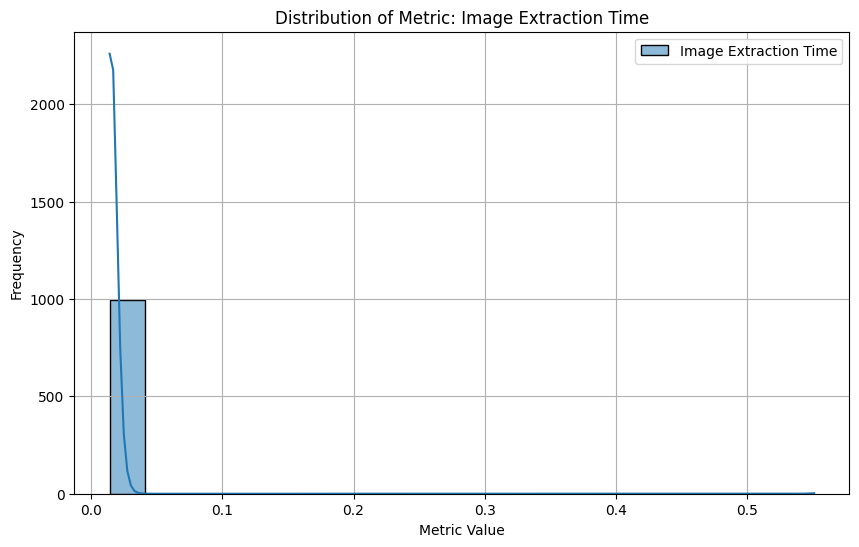

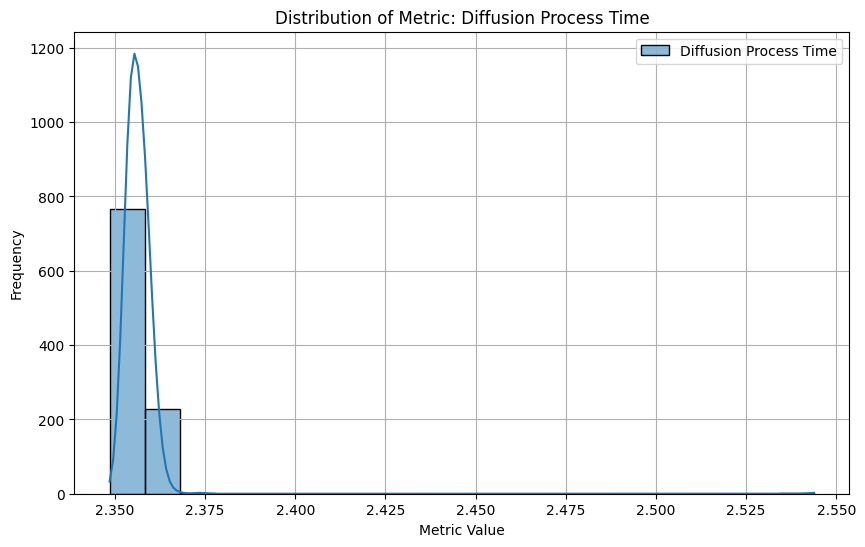

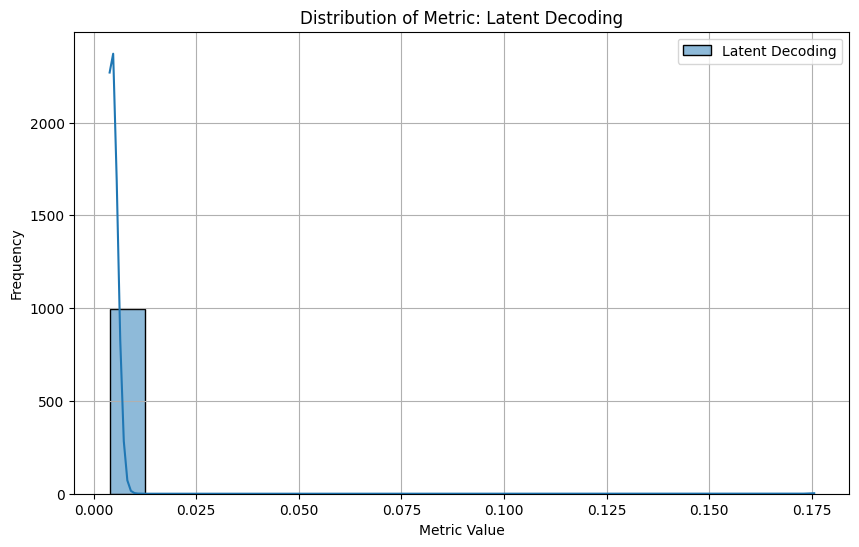

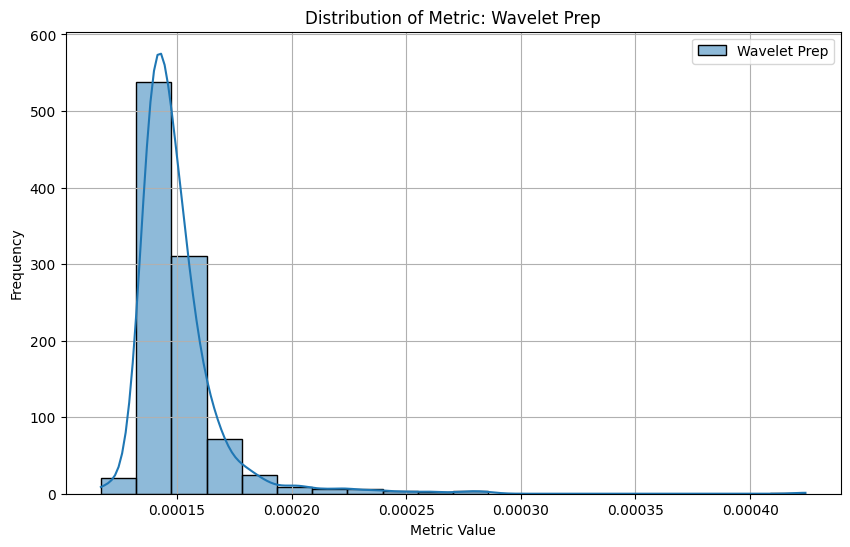

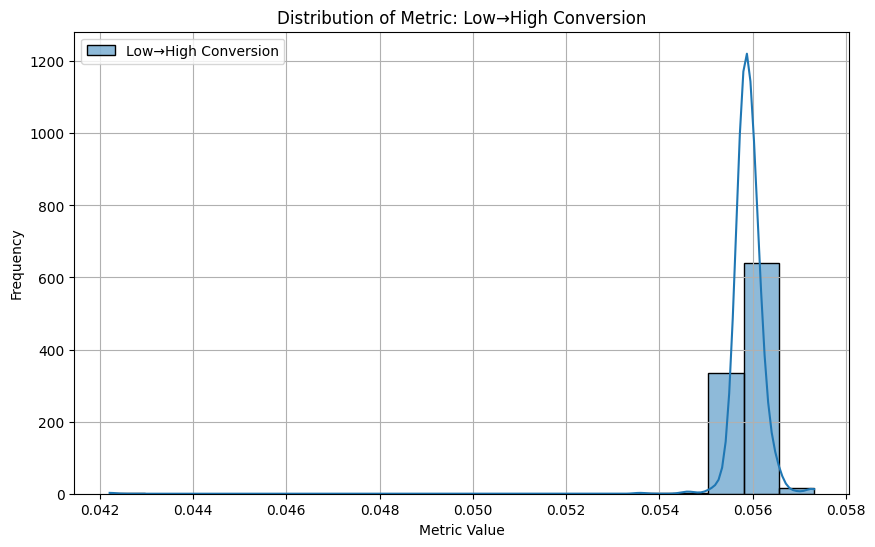

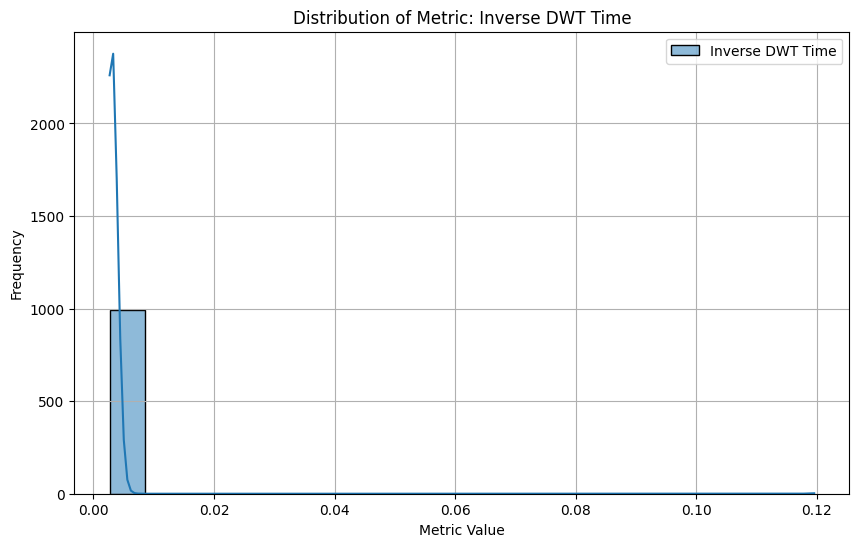

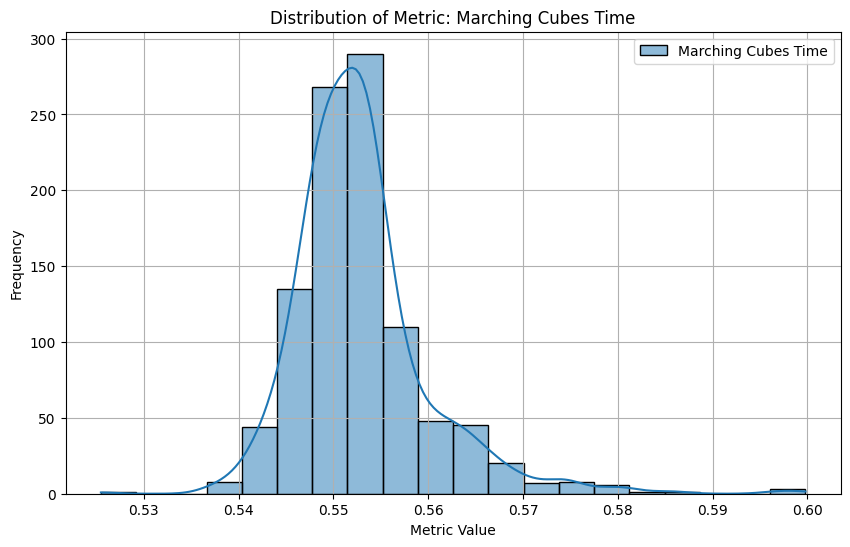

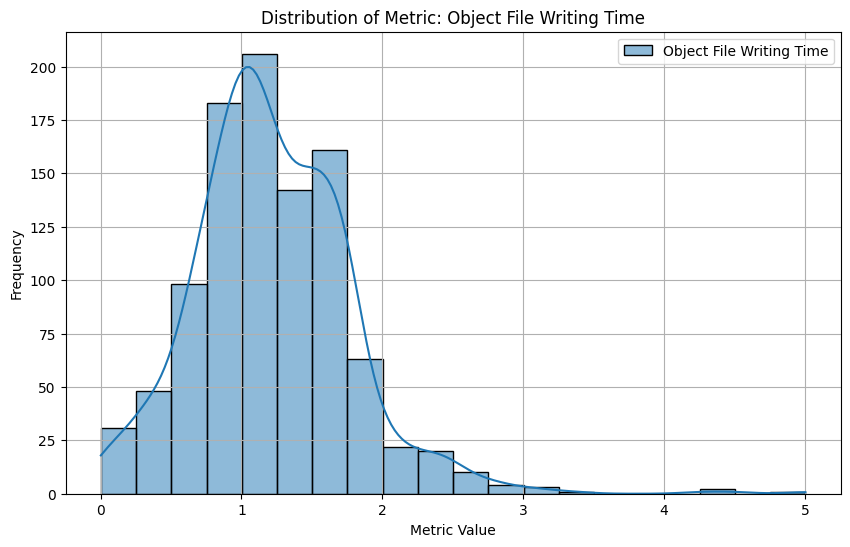

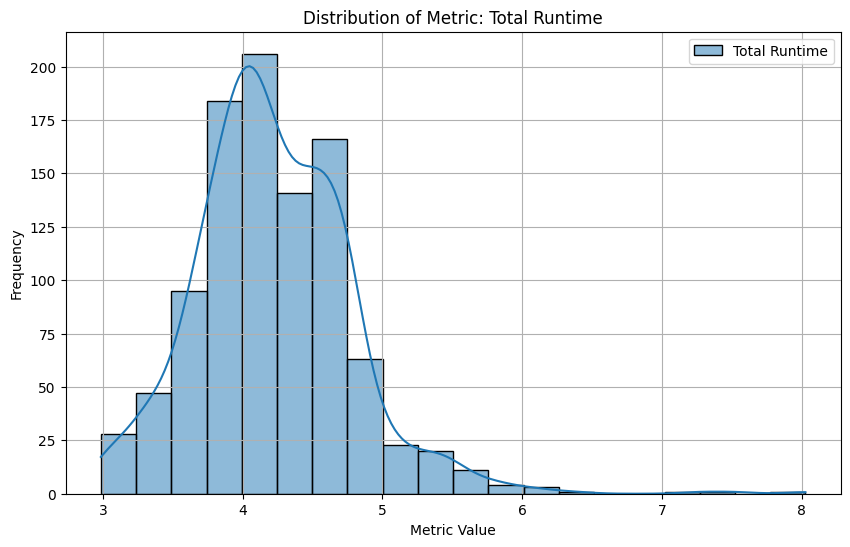

In [18]:
api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ"
comet_api = API(api_key=api_key)
project_name="wala-time-checks"
workspace="alessandro-giuliano"
experiment_key = '1bf42d8c3ee545628968903512893acf'
experiment_keys = {'Benchmark':'1bf42d8c3ee545628968903512893acf','mcubes_fast_write':'223ac82d90fc4292a33c60cc93e9f929','Simplified Mesh':'7fa0d3b99b0d48588f11da362ed52aca'}
# Retrieve the experiment
experiment = comet_api.get_experiment(workspace, project_name, experiment_keys['mcubes_fast_write'])

def retrieve_and_plot(experiment, metric_names=None, metric_display_names=None, plotting=True):
    if metric_names is None:
        metric_names = [
            "Extract Image",
            "Latent Diffusion Time",
            "Latent Decoding Time",
            "Wavelet Preparation Time",
            "Low to Highs conversion",
            "Inverse DWT time elapsed",    
            "mcubes.marching_cubes time",
            "export obj time",
            "Default Delta"
        ]
    if metric_display_names is None:
        metric_display_names = {
            "Extract Image": "Image Extraction Time",
            "Latent Diffusion Time": "Diffusion Process Time",
            "Latent Decoding Time": "Latent Decoding",
            "Wavelet Preparation Time": "Wavelet Prep",
            "Low to Highs conversion": "Low→High Conversion",
            "Inverse DWT time elapsed": "Inverse DWT Time",
            "mcubes.marching_cubes time": "Marching Cubes Time",
            "export obj time": "Object File Writing Time",
            "Default Delta": "Total Runtime"
        }

    all_metric_data = {}

    # Plot the distribution of each metric in a separate figure
    for metric_name in metric_names:
        # Retrieve metric data
        metric_data = experiment.get_metrics(metric_name)
        # Extract values and convert to float
        values = [float(point["metricValue"]) for point in metric_data]
        all_metric_data[metric_name] = values

        display_name = metric_display_names.get(metric_name, metric_name)
        
        if plotting:
            plt.figure(figsize=(10, 6))
            sns.histplot(values, kde=True, bins=20, label=display_name)
            plt.xlabel("Metric Value")
            plt.ylabel("Frequency")
            plt.title(f"Distribution of Metric: {display_name}")
            plt.legend()
            plt.grid()
            plt.show()
    
   

    return all_metric_data, metric_names, metric_display_names
 

all_metric_data, metric_names, metric_display_names = retrieve_and_plot(experiment,plotting = True)


In [19]:
def get_stats(experiment, metric_names, display=False):
    """
    Retrieve and calculate statistics for each metric in an experiment.
    Returns the metric statistics dictionary and the Default Delta values.
    Optionally prints the statistics if display=True.
    """
    metric_statistics = {}
    total_sum = 0
    metric_names = [name for name in metric_names if name != "Default Delta"]

    
    for metric_name in metric_names:
        # Retrieve metric data
        metric_data = experiment.get_metrics(metric_name)
        # Extract values and convert to float
        values = [float(point["metricValue"]) for point in metric_data]
        
        # Calculate statistics
        metric_stats = {
            "mean": np.mean(values),
            "median": np.median(values),
            "min": np.min(values),
            "max": np.max(values),
            "sum": np.sum(values)
        }
        metric_statistics[metric_name] = metric_stats
        total_sum += metric_stats["sum"]

    # Retrieve the "Default Delta" metric
    default_delta_data = experiment.get_metrics("Default Delta")
    default_delta_values = [float(point["metricValue"]) for point in default_delta_data]
    default_delta_sum = np.sum(default_delta_values)

    if display:
        print("Metric Statistics:")
        for metric_name, stats in metric_statistics.items():
            print(f"\n{metric_name}:")
            for stat_name, value in stats.items():
                print(f"  {stat_name.capitalize()}: {value:.4f}")

        print(f"\nTotal Sum of All Metrics (excluding Default Delta): {total_sum:.4f}")
        print(f"Default Delta Sum: {default_delta_sum:.4f}")

        # Check if the total sum is close to the Default Delta
        if np.isclose(total_sum, default_delta_sum, atol=20):  # Adjust tolerance as needed
            percentage_difference = (total_sum / default_delta_sum) * 100
            print(f"\nThe total sum of all metrics is {percentage_difference:.2f}% of the Default Delta.")
        else:
            print("\nThe total sum of all metrics is NOT close to the Default Delta.")

    return metric_statistics, default_delta_values
metric_statistics, default_delta_values = get_stats(experiment, metric_names, display = True)


Metric Statistics:

Extract Image:
  Mean: 0.0160
  Median: 0.0150
  Min: 0.0140
  Max: 0.5512
  Sum: 15.9127

Latent Diffusion Time:
  Mean: 2.3565
  Median: 2.3560
  Min: 2.3485
  Max: 2.5439
  Sum: 2344.7092

Latent Decoding Time:
  Mean: 0.0046
  Median: 0.0044
  Min: 0.0039
  Max: 0.1756
  Sum: 4.6169

Wavelet Preparation Time:
  Mean: 0.0002
  Median: 0.0001
  Min: 0.0001
  Max: 0.0004
  Sum: 0.1495

Low to Highs conversion:
  Mean: 0.0559
  Median: 0.0559
  Min: 0.0422
  Max: 0.0573
  Sum: 55.6160

Inverse DWT time elapsed:
  Mean: 0.0032
  Median: 0.0031
  Min: 0.0027
  Max: 0.1196
  Sum: 3.1850

mcubes.marching_cubes time:
  Mean: 0.5529
  Median: 0.5521
  Min: 0.5255
  Max: 0.5998
  Sum: 550.1513

export obj time:
  Mean: 1.2203
  Median: 1.1639
  Min: 0.0018
  Max: 5.0037
  Sum: 1214.2202

Total Sum of All Metrics (excluding Default Delta): 4188.5609
Default Delta Sum: 4199.2148

The total sum of all metrics is 99.75% of the Default Delta.


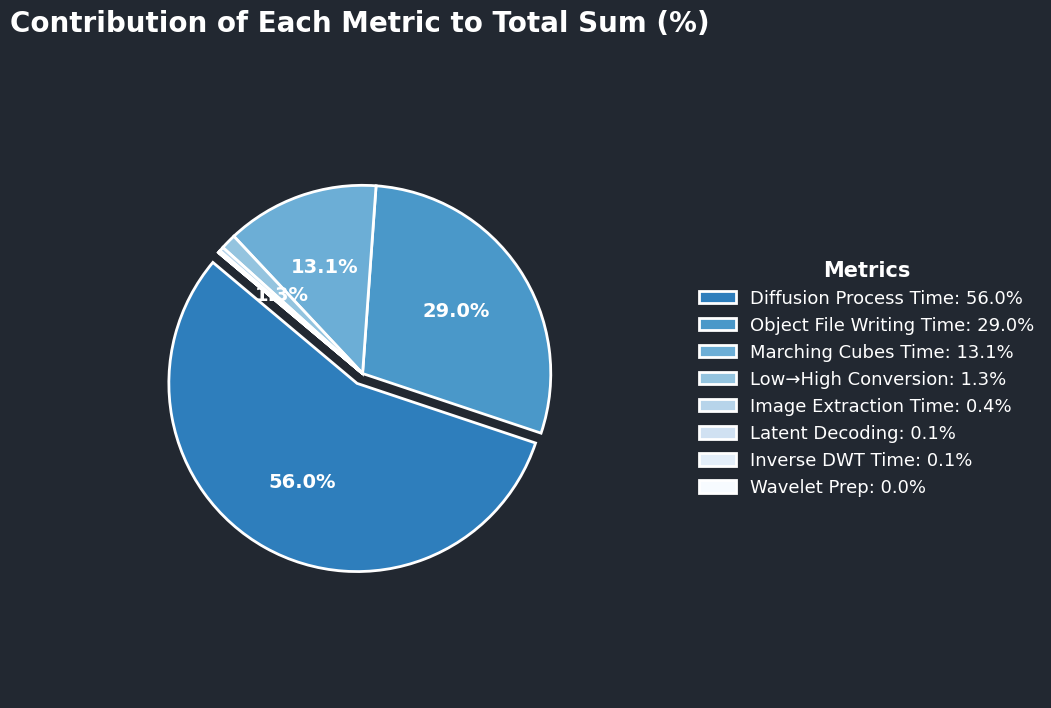

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric_pie(metric_statistics, metric_display_names, title='Contribution of Each Metric to Total Sum (%)'):
    plt.rcParams['font.family'] = 'DejaVu Sans'

    labels = []
    sizes = []
    for metric_name, stats in metric_statistics.items():
        display_name = metric_display_names.get(metric_name, metric_name)
        labels.append(display_name)
        sizes.append(stats["sum"])

    # Calculate percentages
    total = sum(sizes)
    percentages = [size / total * 100 for size in sizes]

    # Sort by size (descending)
    sorted_indices = np.argsort(sizes)[::-1]
    labels = [labels[i] for i in sorted_indices]
    sizes = [sizes[i] for i in sorted_indices]
    percentages = [percentages[i] for i in sorted_indices]

    # Use an inverted (reversed) colormap for light slices
    cmap = plt.get_cmap('Blues_r')
    colors = [cmap(0.3 + 0.7 * i / (len(labels)-1)) for i in range(len(labels))]

    # Explode the largest slice
    explode = [0.06 if i == 0 else 0 for i in range(len(labels))]

    fig, ax = plt.subplots(figsize=(11, 8))
    fig.patch.set_facecolor('#222831')  # Dark background
    ax.set_facecolor('#222831')

    # Pie chart with white edge, no shadow
    wedges, texts, autotexts = ax.pie(
        sizes,
        colors=colors,
        startangle=140,
        autopct=lambda pct: f"{pct:.1f}%" if pct > 0.5 else '',
        textprops={'fontsize': 14, 'fontweight': 'bold', 'color': 'white'},
        explode=explode,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}
    )

    # Add a legend with full labels and percentages
    legend_labels = [f"{label}: {percent:.1f}%" for label, percent in zip(labels, percentages)]
    legend = ax.legend(
        wedges, legend_labels, title="Metrics", loc="center left",
        bbox_to_anchor=(1.05, 0.5), fontsize=13, title_fontsize=15, frameon=False, labelcolor='white'
    )
    plt.setp(legend.get_title(), fontweight='bold', color='white')

    plt.title(title, fontsize=20, fontweight='bold', pad=20, color='white')
    plt.axis('equal')
    plt.tight_layout(pad=4)
    plt.show()

plot_metric_pie(metric_statistics,metric_display_names)

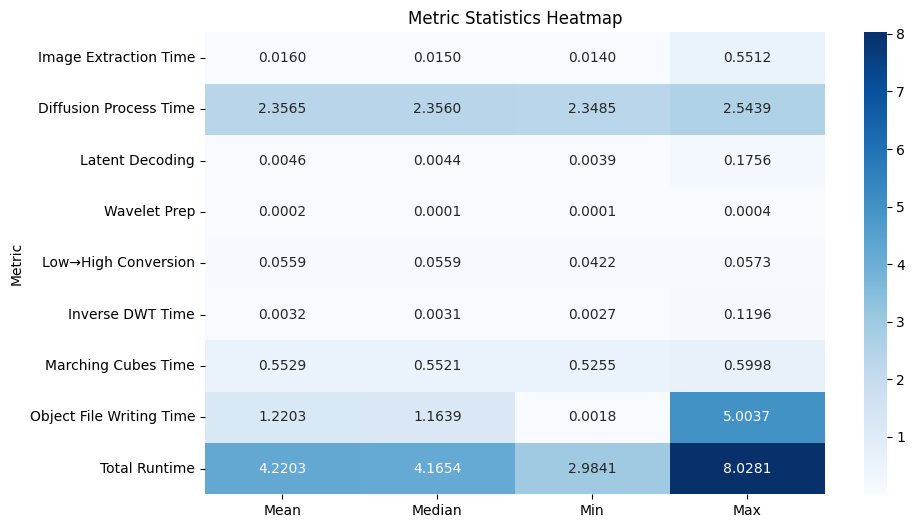

In [21]:

def plot_metric_heatmap(
    metric_statistics,
    metric_display_names,
    default_delta_values,
    include_min=True,
    include_max=True,
    include_median=True,
    title="Metric Statistics Heatmap"
):
    # Prepare columns based on options
    columns = ["Metric", "Mean"]
    if include_median:
        columns.append("Median")
    if include_min:
        columns.append("Min")
    if include_max:
        columns.append("Max")

    data = {col: [] for col in columns}

    for metric_name, stats in metric_statistics.items():
        display_name = metric_display_names.get(metric_name, metric_name)
        data["Metric"].append(display_name)
        data["Mean"].append(stats["mean"])
        if include_median:
            data["Median"].append(stats["median"])
        if include_min:
            data["Min"].append(stats["min"])
        if include_max:
            data["Max"].append(stats["max"])

    # Add Default Delta statistics as "Total Runtime"
    default_delta_stats = {
        "mean": np.mean(default_delta_values),
        "median": np.median(default_delta_values),
        "min": np.min(default_delta_values),
        "max": np.max(default_delta_values)
    }
    data["Metric"].append("Total Runtime")
    data["Mean"].append(default_delta_stats["mean"])
    if include_median:
        data["Median"].append(default_delta_stats["median"])
    if include_min:
        data["Min"].append(default_delta_stats["min"])
    if include_max:
        data["Max"].append(default_delta_stats["max"])

    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.set_index("Metric"), annot=True, fmt=".4f", cmap="Blues")
    plt.title(title)
    plt.show()

plot_metric_heatmap(
    metric_statistics,
    metric_display_names,
    default_delta_values,
    include_min=True,
    include_max=True,
    include_median=True
)

#### Display Comparisons

WaLa Original: mean = 2.5208, std = 1.1495
WaLa MCubes Fast Write: mean = 1.2203, std = 0.5583


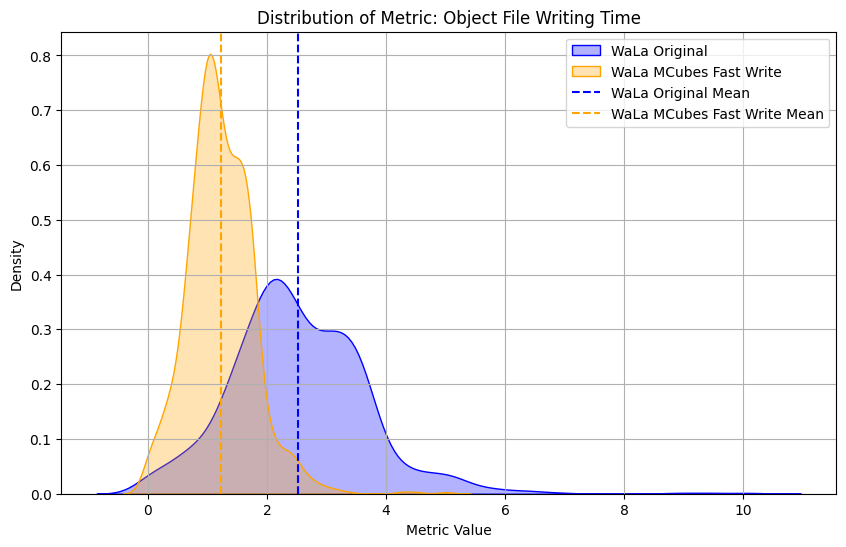

Percentage change in mean: -51.59%
WaLa Original: mean = 5.5203, std = 1.1545
WaLa MCubes Fast Write: mean = 4.2203, std = 0.5620


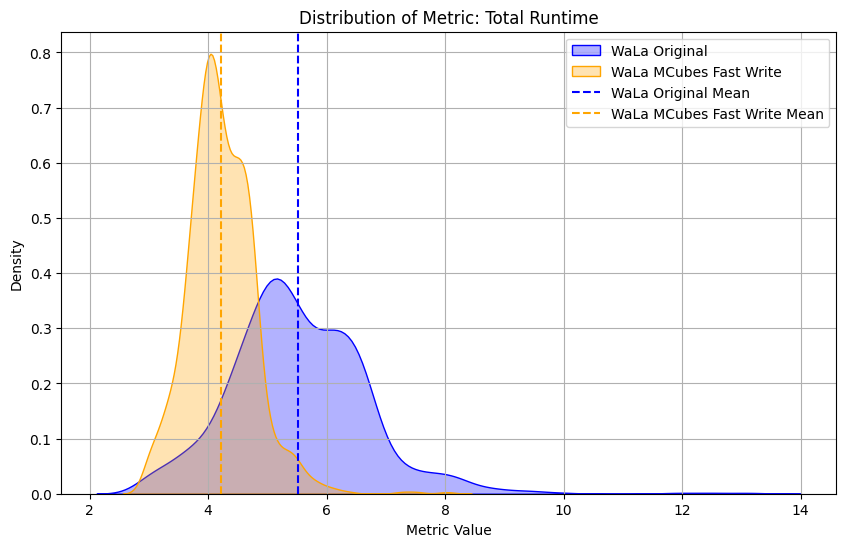

Percentage change in mean: -23.55%


In [17]:
def compare_metric_distribution(
    experiment1, experiment2, 
    metric_name, 
    label1="Experiment 1", 
    label2="Experiment 2", 
    display_name=None
):
    # Retrieve metric data for both experiments
    values1 = [float(point["metricValue"]) for point in experiment1.get_metrics(metric_name)]
    values2 = [float(point["metricValue"]) for point in experiment2.get_metrics(metric_name)]
    
    # Calculate mean and std
    mean1, std1 = np.mean(values1), np.std(values1)
    mean2, std2 = np.mean(values2), np.std(values2)
    
    # Print mean and std
    print(f"{label1}: mean = {mean1:.4f}, std = {std1:.4f}")
    print(f"{label2}: mean = {mean2:.4f}, std = {std2:.4f}")
    
    plt.figure(figsize=(10, 6))
    # KDE plots
    sns.kdeplot(values1, color='blue', label=label1, fill=True, alpha=0.3)
    sns.kdeplot(values2, color='orange', label=label2, fill=True, alpha=0.3)
    # Plot means
    plt.axvline(mean1, color='blue', linestyle='--', label=f"{label1} Mean")
    plt.axvline(mean2, color='orange', linestyle='--', label=f"{label2} Mean")
    
    # Annotate mean and std on the plot
    #plt.text(mean1, plt.ylim()[1]*0.9, f"μ={mean1:.2f}\nσ={std1:.2f}", color='blue', ha='center')
    #plt.text(mean2, plt.ylim()[1]*0.8, f"μ={mean2:.2f}\nσ={std2:.2f}", color='orange', ha='center')
    
    plt.xlabel("Metric Value")
    plt.ylabel("Density")
    plt.title(f"Distribution of Metric: {display_name or metric_name}")
    plt.legend()
    plt.grid()
    plt.show()

    # Print percentage change in means
    if mean1 != 0:
        pct_change = ((mean2 - mean1) / mean1) * 100
        print(f"Percentage change in mean: {pct_change:.2f}%")
    else:
        print("Cannot compute percentage change: mean of first experiment is zero.")

# Retrieve both experiments
experiment1 = comet_api.get_experiment(workspace, project_name, experiment_keys['Benchmark'])
experiment2 = comet_api.get_experiment(workspace, project_name, experiment_keys['mcubes_fast_write'])


# Compare "export obj time"
compare_metric_distribution(
    experiment1, experiment2, 
    metric_name="export obj time", 
    label1="WaLa Original", 
    label2="WaLa MCubes Fast Write", 
    display_name="Object File Writing Time"
)

# Compare "Default Delta" (total runtime)
compare_metric_distribution(
    experiment1, experiment2, 
    metric_name="Default Delta", 
    label1="WaLa Original", 
    label2="WaLa MCubes Fast Write",
    display_name="Total Runtime"
)



### Custom Optimization Implementations

#### Mcubes object export/ write object to file

In [2]:

def export_obj_original(vertices: np.ndarray, triangles: np.ndarray, filename: str, flip_normals: bool = False):
    """
    Export a 3D mesh to a Wavefront (.obj) file.

    If `flip_normals` is True, reverses the order of the vertices in each face
    to flip the normals. Default is False.
    """

    with open(filename, 'w') as fh:

        for v in vertices:
            fh.write("v {} {} {}\n".format(*v))

        if not flip_normals:
            for f in triangles:
                fh.write("f {} {} {}\n".format(*(f + 1)))
        else:
            for f in triangles:
                fh.write("f {} {} {}\n".format(*(f[::-1] + 1)))


def export_obj_fast(vertices: np.ndarray, triangles: np.ndarray, filename: str, flip_normals: bool = False):
    """
    Export a 3D mesh to a Wavefront (.obj) file, optimized for speed.
    """
    with open(filename, 'w') as fh:
        # Write vertices
        np.savetxt(fh, vertices, fmt='v %.6f %.6f %.6f')
        # Prepare faces (OBJ is 1-based indexing)
        if not flip_normals:
            np.savetxt(fh, triangles + 1, fmt='f %d %d %d')
        else:
            np.savetxt(fh, triangles[:, ::-1] + 1, fmt='f %d %d %d')

In [7]:
import numpy as np
import time
import mcubes.exporter

# Generate a large random mesh for testing
num_vertices = 100_000
num_faces = 200_000

vertices = np.random.rand(num_vertices, 3)
triangles = np.random.randint(0, num_vertices, size=(num_faces, 3))

def benchmark_export(func, vertices, triangles, filename, flip_normals=False):
    start = time.time()
    func(vertices, triangles, filename, flip_normals)
    end = time.time()
    return end - start

# Test and compare
filename1 = "test_original.obj"
filename2 = "test_optimized.obj"

t1 = benchmark_export(export_obj_fast, vertices, triangles, filename1)
t2 = benchmark_export(export_obj_original, vertices, triangles, filename2)

print(f"Original export_obj_original time: {t2:.4f} seconds")
print(f"Optimized export_obj time: {t1:.4f} seconds")
print(f"Speedup: {t2/t1:.2f}x faster")

Original export_obj_original time: 1.1928 seconds
Optimized export_obj time: 0.6748 seconds
Speedup: 1.77x faster
